In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from seaborn import barplot
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k#, AUC_at_k, ndcg_at_k

In [2]:
data = pd.read_csv('retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [4]:
items_weights = data.groupby('item_id')['user_id'].nunique().reset_index()
items_weights.columns = ['item_id', 'weight']
items_weights.weight /= items_weights.shape[0]

items_weights.head()

,item_id,weight
0,25671,0.000034
1,26081,0.000011
2,26093,0.000011
3,26190,0.000011
4,26355,0.000011


In [5]:
items_weights = data.groupby('item_id')['sales_value'].sum().reset_index()
items_weights.columns = ['item_id', 'weight']
items_weights.weight = items_weights.weight.apply(lambda x: np.log(x) if np.log(x) > 0 else 0)
items_weights.weight /= items_weights.weight.sum()

items_weights.head()

,item_id,weight
0,25671,0.000013
1,26081,0.000000
2,26093,0.000002
3,26190,0.000002
4,26355,0.000003


In [6]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    
    np.random.seed(0)

    items = items_weights.item_id
    weights = items_weights.weight

    recs = np.random.choice(items, size=n, replace=False, p=weights)

    return recs.tolist()

In [7]:
result = pd.read_csv('predictions_basic.csv')

# Преобразование из объекта-строки в список значений int32
for column in ['actual', 'random_recommendation', 'popular_recommendation',
               'itemitem', 'cosine', 'tfidf', 'own_purchases']:
    result[column] = result[column].apply(\
               lambda xx: [np.int32(x) for x in re.findall('[0-9]+', xx)])    

result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[5586238, 1015228, 866118, 2416733, 2603573]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 1127831, 1098066, 826249, 878996]","[981760, 1127831, 1098066, 878996, 826249]","[981760, 1127831, 1098066, 826249, 878996]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[161354, 63027, 1027802, 12263694, 307395]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 995242, 1029743, 840361, 961554]","[981760, 1004906, 961554, 1096036, 1080414]","[981760, 1004906, 859075, 1096036, 961554]","[999999, 1082185, 1098066, 6534178, 1127831]"


In [8]:
%%time

result['weighted_random_recommendation'] = result.user_id.apply(lambda x: weighted_random_recommendation(items_weights, n=5))
result.head(2)

Wall time: 4.58 s


,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[5586238, 1015228, 866118, 2416733, 2603573]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 1127831, 1098066, 826249, 878996]","[981760, 1127831, 1098066, 878996, 826249]","[981760, 1127831, 1098066, 826249, 878996]","[999999, 1082185, 1029743, 995785, 1004906]","[1134635, 8091034, 3715585, 1132178, 1057503]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[161354, 63027, 1027802, 12263694, 307395]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 995242, 1029743, 840361, 961554]","[981760, 1004906, 961554, 1096036, 1080414]","[981760, 1004906, 859075, 1096036, 961554]","[999999, 1082185, 1098066, 6534178, 1127831]","[1134635, 8091034, 3715585, 1132178, 1057503]"


### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [9]:
def precision_at_k(x, k=5):
    
    bought_list, recommended_list = x[0], x[1]
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)    
    
    return precision * 100

In [10]:
k = 5
rec_columns = ['random_recommendation', 'popular_recommendation',
               'itemitem', 'cosine', 'tfidf', 'own_purchases',
               'weighted_random_recommendation']

precision_values = []
for column in rec_columns:
    precision_value = result[['actual', column]].apply( \
         lambda x: precision_at_k(x, k), axis=1).mean()
    precision_values.append(precision_value)    

In [11]:
mean_precision_at_k = pd.DataFrame({'rec_columns': rec_columns,
                                    'precision_values': precision_values})
mean_precision_at_k.sort_values(by='precision_values', ascending=False, inplace=True)
mean_precision_at_k.reset_index(drop=True)

,rec_columns,precision_values
0,own_purchases,17.998694
1,popular_recommendation,15.523996
2,tfidf,3.614104
3,cosine,3.525955
4,itemitem,3.359452
5,random_recommendation,0.058766
6,weighted_random_recommendation,0.048972


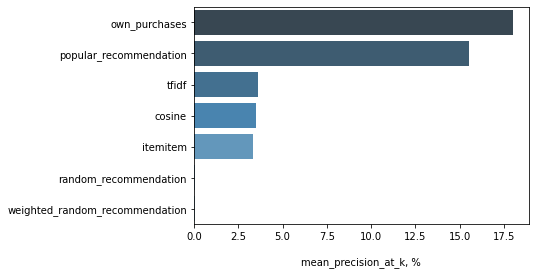

In [12]:
barplot(x='precision_values', y='rec_columns', data=mean_precision_at_k, orient='h', palette='Blues_d')
plt.xlabel('\nmean_precision_at_k, %')
plt.ylabel('')
plt.show()

**Выводы:**
 - наилучшие результаты по Precision@5 дали рекомендации самых популярных товаров (*popular_recommendation*) и наиболее близких к уже купленным товаром (*own_purchases*);
 - по метрике также видно, что ItemItem-алгоритм действительно улучшается взвешиванием (*cosine* и *tfidf*);
 - случайные рекомендации показали самый худший результат.

### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.

In [13]:
# your_code